# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка.

Для практики будем решать задачу оттока клиентов из банка, датасет для выполнения практики - [**здесь**](https://lms.skillfactory.ru/assets/courseware/v1/1e9752711f76fc98e2e431c7c65bb420/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ML-3_churn.zip).

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов.

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на 2 части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.

Для начала импортируем библиотеки, которые нам понадобятся:

In [1]:
import os, sys, re
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# установка стиля matplotlib
%matplotlib inline
plt.style.use('seaborn-v0_8')

# доступные стили отображения графика в matplotlib
# plt.style.available

# from ydata_profiling import ProfileReport         # отключено пока не "починят"
import sweetviz as sv
import dtale
import statistics as stcs
import statsmodels.stats.proportion as stsmdls

# библиотека для расчетов корреляций
from scipy import stats
from sklearn import metrics

# для нормализации, стандартизации
from sklearn import preprocessing

# библиотека модели линейной регрессии
from sklearn import linear_model

# библиотека модели деревьев решения
from sklearn import tree

# библиотека модели ансамблей
from sklearn import ensemble

# библиотека для разделения датасета
from sklearn.model_selection import train_test_split

# библиотека для кодирования признаков
import category_encoders as ce

# для обработки timestamp в формате utc
import datetime, time

# работа с json
import json
from pprint import pprint

# веб-скрэпинг сайтов
import requests
from bs4 import BeautifulSoup

# выводить все результаты вычислений в ячейках Code
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# подключить Latex
from IPython.display import Latex

# скрытие сообщений об ошибках при обработке ответов
import warnings
# игнорируем предупреждения
warnings.filterwarnings('ignore')

# изменить формат вывода pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.set_option('display.max_info_rows', 500)
# pd.set_option('display.max_info_columns', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.large_repr', 'truncate')

Итак, прочитаем нашу таблицу:

In [2]:
churn_data = pd.read_csv('./data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Напомним значения столбцов:

* **RowNumber** — номер строки таблицы;
* **CustomerId** — идентификатор клиента;
* **Surname** — фамилия клиента;
* **CreditScore** — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);
* **Geography** — страна проживания клиента (банк межнациональный);
* **Gender** — пол клиента;
* **Age** — возраст клиента;
* **Tenure** — сколько лет клиент пользуется банком;
* **Balance** — сколько у клиента денег на счетах в банке;
* **NumOfProduct** — число услуг банка, которые приобрёл клиент;
* **HasCrCard** — есть ли у клиента кредитная карта (1 — да, 0 — нет);
* **IsActiveMember** — есть ли у клиента статус активного участника банка (1 — да, 0 — нет);
* **EstimatedSalary** — предполагаемая заработная плата клиента;
* **Exited** — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

In [3]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

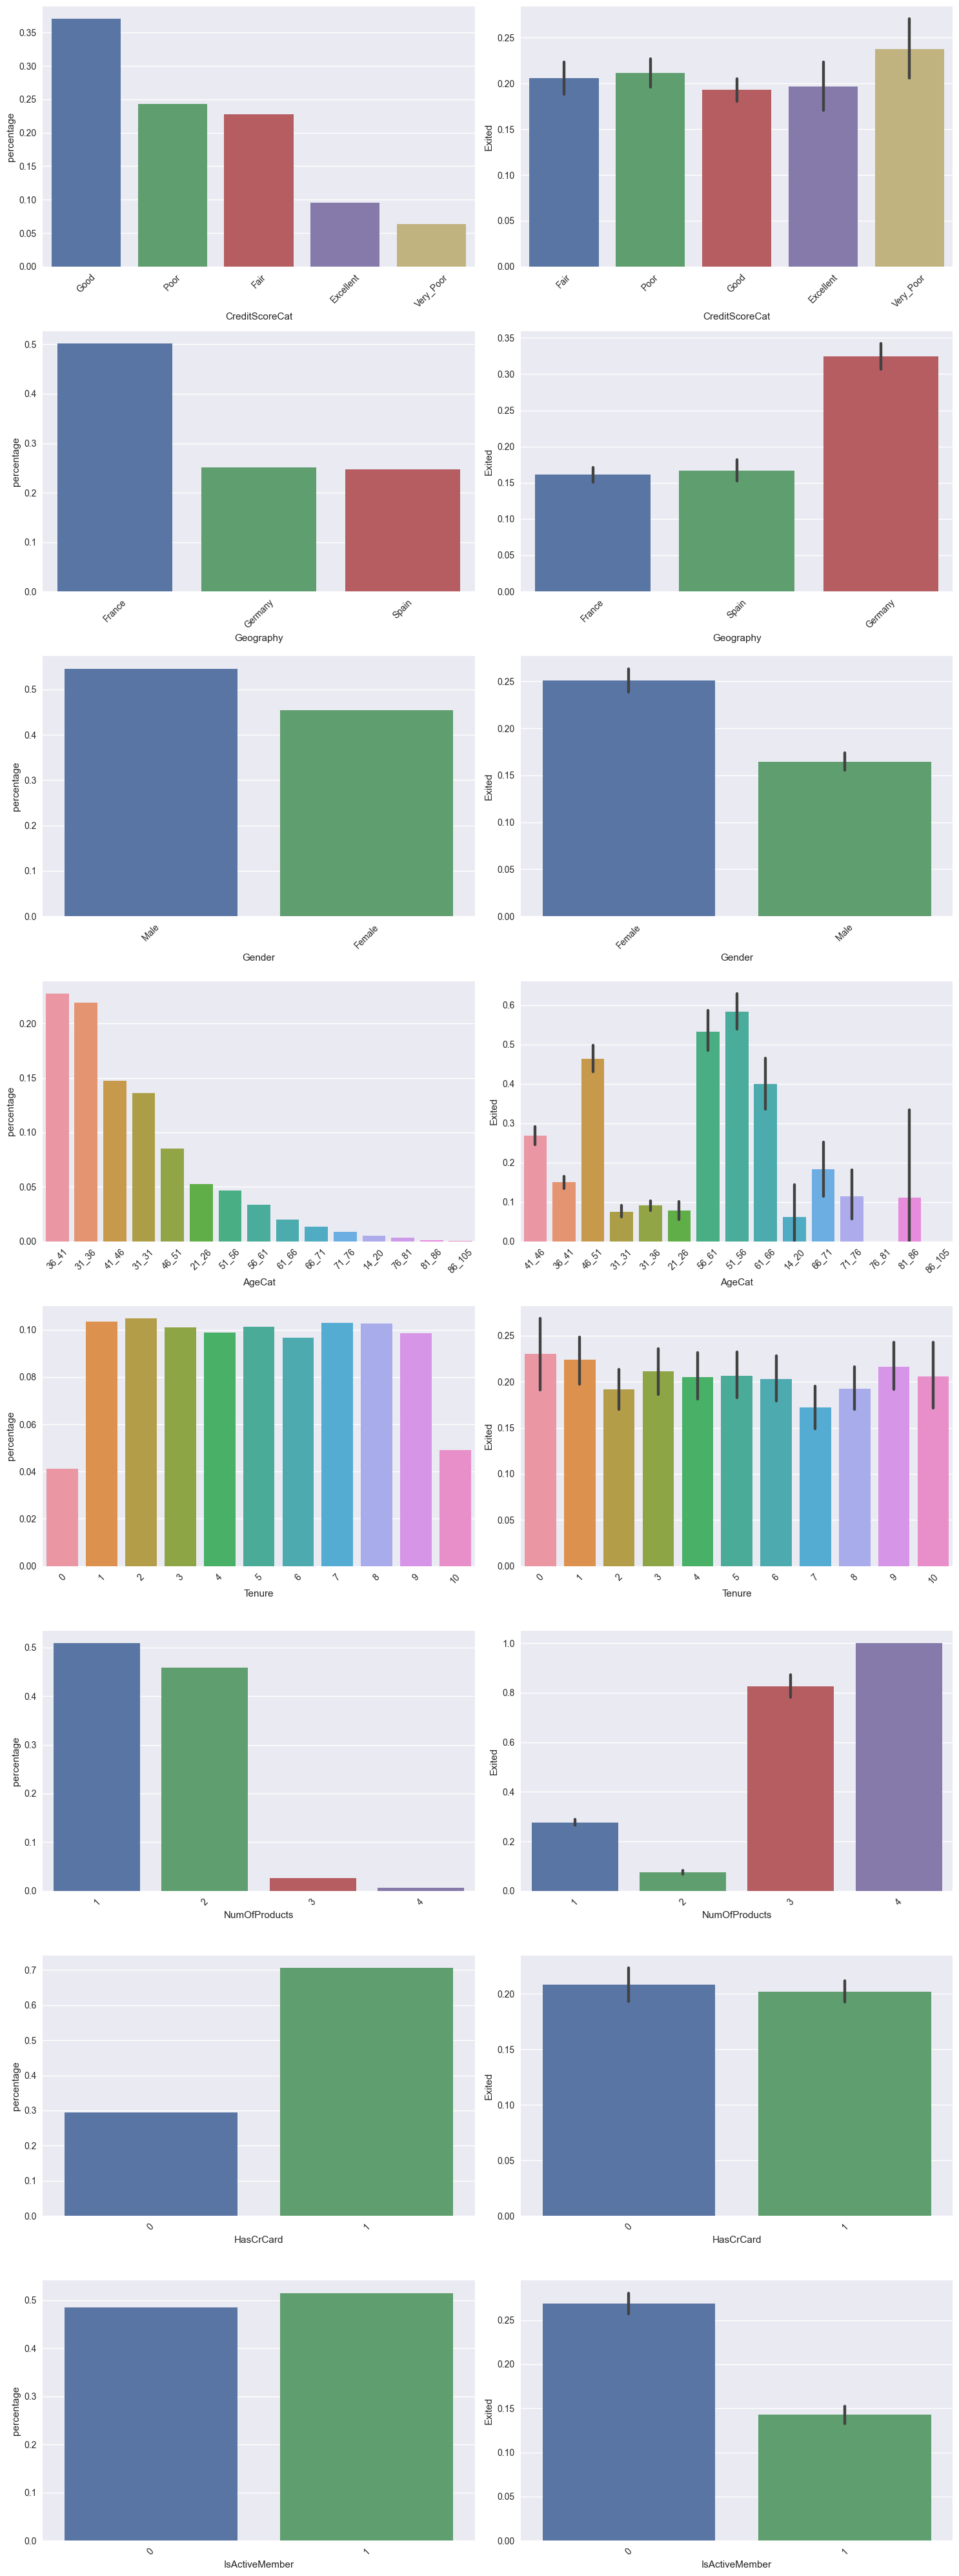

In [4]:
# функция перевода числового признака 'CreditScore' в категориальный
def get_credit_score_rate(credit_sc:int) -> str:
    """ Функция присвоения кредитной категории по кредитному рейтингу

    Args:
        credit_sc (int): числовое значение кредитного рейтинга

    Returns:
        str: категориальное значение кредитного рейтинга
    """
    if credit_sc in range (0, 300)  : return "Deep"
    if credit_sc in range (300, 500): return "Very_Poor"
    if credit_sc in range (500, 601): return "Poor"
    if credit_sc in range (601, 661): return "Fair"
    if credit_sc in range (661, 781): return "Good"
    if credit_sc in range (781, 851): return "Excellent"
    if credit_sc in range (851, 999): return "Top"

# функция перевода числового признака 'Age' в категориальный
def get_age_cat(age:int) -> str:
    """ Функция присвоения возрастной категории по возрасту

    Args:
        age (int): числовое значение возраста

    Returns:
        str: категориальное значение возраста
    """
    if age in range (14, 20) : return "14_20"
    if age in range (21, 26) : return "21_26"
    if age in range (26, 31) : return "31_31"
    if age in range (31, 36) : return "31_36"
    if age in range (36, 41) : return "36_41"
    if age in range (41, 46) : return "41_46"
    if age in range (46, 51) : return "46_51"
    if age in range (51, 56) : return "51_56"
    if age in range (56, 61) : return "56_61"
    if age in range (61, 66) : return "61_66"
    if age in range (66, 71) : return "66_71"
    if age in range (71, 76) : return "71_76"
    if age in range (76, 81) : return "76_81"
    if age in range (81, 86) : return "81_86"
    if age in range (86, 105): return "86_105"

# формирование нового признака 'CreditScoreCat'
churn_data['CreditScoreCat'] = churn_data['CreditScore'].apply(get_credit_score_rate)

# формирование нового признака 'AgeCat'
churn_data['AgeCat'] = churn_data['Age'].apply(get_age_cat)

features = ['CreditScoreCat', 'Geography', 'Gender', 'AgeCat', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

n = len(features)                                       # число признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40))        # фигура + n*2 координатных плоскостей

# цикл для всех признаков из списка
for i, feature in enumerate(features):
    # формируем сводную таблицу
    count_data = (churn_data[feature].value_counts(normalize=True)
        .sort_values(ascending=False)
        .rename('percentage')
        .reset_index()
    )
    # строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    count_barplot = sns.barplot(
        data=count_data, 
        x='index', 
        y='percentage', 
        ax=axes[i][0]
    )
    # поворот меток на оси абсцисс на 45 градусов
    count_barplot.xaxis.set_tick_params(rotation=45)
    # задаём название оси абсцисс
    count_barplot.set(xlabel=feature)

    # строим столбчатую диаграмму доли людей ушедших из банка в зависимости от признака
    mean_barplot = sns.barplot(data=churn_data, x=feature, y='Exited', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout();                                     # выравнивание графиков

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [5]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 16)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [6]:
# также избавляюсь от новых категориальных признаков, т.к. нужны были только для построения графиков
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname', 'CreditScoreCat', 'AgeCat'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [7]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [8]:
churn_data[churn_data.duplicated()].sum()

CreditScore        0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [9]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure'] / (churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / (churn_data['Age'])

# перекодируем единичный текстовый категориальный признак 'Gender' в бинарный столбец (1 — 'Male', 0 — 'Female')
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [10]:
X = churn_data.drop('Exited', axis=1)
y = churn_data['Exited']

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [11]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**.

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак $y$.

Выполним разбиение, установив значение параметра `random_state` на 0:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_train.shape}')

Train shape: (1881, 12)
Test shape: (1881, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [13]:
print(f'Train: \n{y_train.value_counts(normalize=True)}\n')
print(f'Test : \n{y_test.value_counts(normalize=True)}')

Train: 
0    0.675704
1    0.324296
Name: Exited, dtype: float64

Test : 
0    0.675159
1    0.324841
Name: Exited, dtype: float64


Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [14]:
# инициализируем нормализатор MinMaxScaler
scaler = preprocessing.MinMaxScaler();

# подгоняем параметры стандартизатора (вычисляем среднее и СКО, средне-квадратичное отклонение)
scaler.fit(X_train);

# производим нормализацию тренировочной выборки
X_train_scaled = scaler.transform(X_train)

# производим нормализацию тестовой выборки
X_test_scaled = scaler.transform(X_test)

MinMaxScaler()

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако, в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 

#### **Выбор и обоснование метрики:**<br>
$F_{1}$, поскольку нам необходимо найти баланс между ***precision*** и ***recall***, то требуется агрегированная метрика, зависящая от этих обеих метрик.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

#### **Объяснение:**<br>
Так как нам, необходимо минимизировать ложноположительную и ложноотрицательную ошибки модели, за это, как раз, отвечают ***precision*** и ***recall***, соответственно, и поскольку надо учитывать обе эти метрики, то проще всего, сразу искать "**F-меру**", она будет максимальна, когда ***precision*** и ***recall*** будут максимальны.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [15]:
# создаём объект класса логистической регрессии с SGD
lr = linear_model.LogisticRegression(
    penalty='l1',
    C=5,
    max_iter=1000,
    solver='saga', 
    random_state=42,
);

# обучаем модель — ищем параметры по методу SGD
lr.fit(X_train_scaled, y_train);

# делаем предсказание для тренировочной выборки
y_train_pred_lr = lr.predict(X_train_scaled)

# делаем предсказание для тестовой выборки
y_test_pred_lr = lr.predict(X_test_scaled)

## вывод отчет о метриках классификации
# ТРЕНИРОВОЧНАЯ ВЫБОРКА
print(f'Train data "F1 score": {metrics.f1_score(y_train, y_train_pred_lr):.3f}')
print(metrics.classification_report(y_train, y_train_pred_lr))

# ТЕСТОВАЯ ВЫБОРКА
print(f'Test data "F1 score": {metrics.f1_score(y_test, y_test_pred_lr):.3f}')
print(metrics.classification_report(y_test, y_test_pred_lr))

LogisticRegression(C=5, max_iter=1000, penalty='l1', random_state=42,
                   solver='saga')

Train data "F1 score": 0.516
              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1271
           1       0.63      0.44      0.52       610

    accuracy                           0.73      1881
   macro avg       0.70      0.66      0.67      1881
weighted avg       0.72      0.73      0.72      1881

Test data "F1 score": 0.496
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       424
           1       0.60      0.42      0.50       204

    accuracy                           0.72       628
   macro avg       0.68      0.64      0.65       628
weighted avg       0.71      0.72      0.71       628



#### **Выводы:**<br>
При использовании следующих параметров обучения модели достигнут наилучший результат с параметрами:
1. Тип регуляризации - `penalty='l1'`, при применении penalty='l2' модель показывает результат несколько хуже на 2-3 знаке после запятой при комбинации вместе с `solver='saga'`;
2. Коэффициент $C$: $C = 5$, при $C = 1$ показывает результат несколько хуже на 2-3 знаке после запятой;
3. Метод оптимизации функции потерь $\text{logloss}$ - `solver='saga'`, единственный параметр при котором возможно построение модели при комбинации вместе с `penalty='l1'`;
4. Максимальное число итераций - `max_iter=1000`, при значении от 20 до 85 - результат ухудшается по сравнению со стандартным значением, результат улучшается на 2-3 знаке после запятой при увеличении max_iter, после 85 - результат не меняется.

В итоге - **модель недообучена на основании целевой метрики $F_{1}$ со значением меньше 0.5**. Значение выше 0.5 только в случае тренировочной выборки, модель адаптирована только под тренировочную выборку.

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [16]:
# создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False);
poly.fit(X_train_scaled);

# генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = poly.transform(X_train_scaled)

# генерируем полиномиальные признаки для тестовой выборки
X_test_scaled_poly = poly.transform(X_test_scaled)

# выводим результирующие размерности таблиц
print(f'Train data shape: {X_train_scaled_poly.shape}')
print(f'Test data shape: {X_test_scaled_poly.shape}')

# создаём объект класса логистической регрессии с SGD
lr_poly = linear_model.LogisticRegression(
    penalty='l1',
    C=500,
    max_iter=1000,
    solver='saga', 
    random_state=42,
);

# обучаем модель с полиномиальными коэффициентами — ищем параметры по методу SGD
lr_poly.fit(X_train_scaled_poly, y_train);

# делаем предсказание на тренировочной выборке
y_train_pred_lr_poly = lr_poly.predict(X_train_scaled_poly)

# делаем предсказание на тестовой выборке
y_test_pred_lr_poly = lr_poly.predict(X_test_scaled_poly)

## вывод отчет о метриках классификации
# ТРЕНИРОВОЧНАЯ ВЫБОРКА
print(f'Train data "F1 score": {metrics.f1_score(y_train, y_train_pred_lr_poly):.3f}')
print(metrics.classification_report(y_train, y_train_pred_lr_poly))

# ТЕСТОВАЯ ВЫБОРКА
print(f'Test data "F1 score": {metrics.f1_score(y_test, y_test_pred_lr_poly):.3f}')
print(metrics.classification_report(y_test, y_test_pred_lr_poly))

PolynomialFeatures(degree=3, include_bias=False)

Train data shape: (1881, 454)
Test data shape: (628, 454)


LogisticRegression(C=500, max_iter=1000, penalty='l1', random_state=42,
                   solver='saga')

Train data "F1 score": 0.734
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1271
           1       0.78      0.69      0.73       610

    accuracy                           0.84      1881
   macro avg       0.82      0.80      0.81      1881
weighted avg       0.83      0.84      0.83      1881

Test data "F1 score": 0.680
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       424
           1       0.71      0.65      0.68       204

    accuracy                           0.80       628
   macro avg       0.78      0.76      0.77       628
weighted avg       0.80      0.80      0.80       628



#### **Выводы:**<br>
При использовании следующих параметров обучения модели достигнут наилучший результат результат с параметрами:
1. Тип регуляризации - `penalty='l1'`, при применении penalty='l2' модель показывает результат несколько хуже на 2-3 знаке после запятой при комбинации вместе с `solver='saga'`;
2. Коэффициент $C$: $C = 500$, при $C = 1$ показывает результат несколько хуже на 1-2 знаке после запятой, дальнейшее увеличение после 500 не приводит к улучшению результата;
3. Метод оптимизации функции потерь $\text{logloss}$ - `solver='saga'`, единственный параметр при котором возможно построение модели при комбинации вместе с `penalty='l1'`;
4. Максимальное число итераций - `max_iter=1000`, при увеличении значения итераций от 100 - результат улучшается по сравнению со стандартным значением на 2-3 знаке после запятой при увеличении max_iter.

В итоге - **модель значительно улучшена на основании целевой метрики $F_{1}$ со значением более 0.5**. При установке стандартных параметров модели логистической регрессии `penalty` и `solver` достигается значение целевой метрики $F_{1}$: 0.75 - для тренировочной выборки и 0.677 - для тестовой. При выборе вышеописанных параметров модель логистической регрессии ослабляет значение целевой метрики $F_{1}$: 0.734 - для тренировочной выборки и улучшает для тестовой выборки - 0.68, данные параметры выбраны как более оптимальные.

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

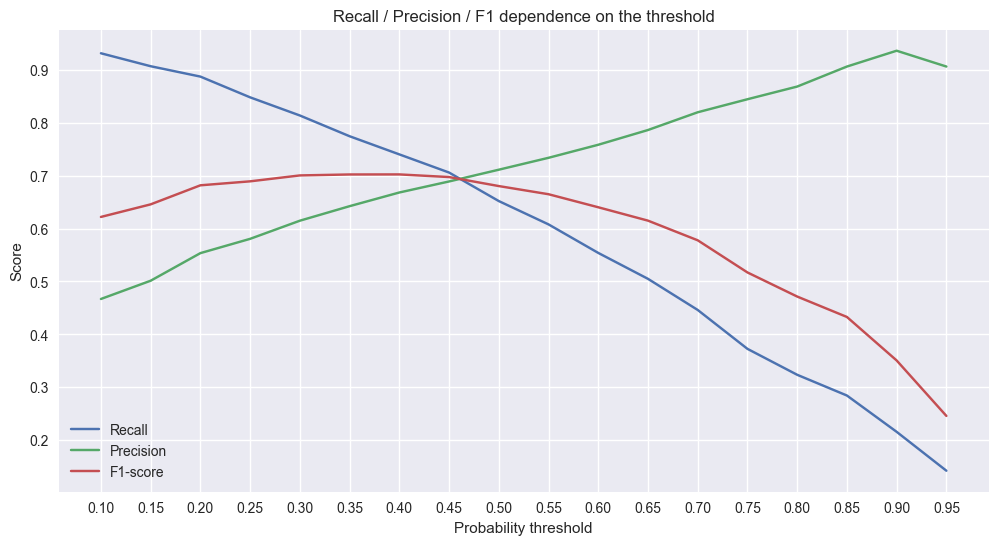

In [17]:
# нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = lr_poly.predict_proba(X_test_scaled_poly)[:, 1]

# для удобства завернём numpy-массив в Pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)

# создаём списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []

# генерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

# в цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    # клиентов, для которых вероятность ухода > threshold, относим к классу 1
    # в противном случае — к классу 0
    y_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    # считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test, y_pred))

# визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(12, 6)) # фигура + координатная плоскость

# строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')

# строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

# строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

# задаём графику название и подписываем оси
ax.set(title='Recall / Precision / F1 dependence on the threshold',
    xlabel='Probability threshold',
    ylabel='Score'
)

# устанавливаем отметки по оси x
ax.set_xticks(thresholds) 

# отображаем легенду
ax.legend();

In [18]:
# задаём оптимальный порог вероятностей
threshold_opt = 0.44

# клиентов, вероятность ухода которых > 0.44 относим к классу 1, в противном случае — к классу 0
# делаем предсказание на тренировочной выборке
y_train_proba_pred = lr_poly.predict_proba(X_train_scaled_poly)[:, 1]
y_train_proba_pred = pd.Series(y_train_proba_pred)
y_train_pred_lr_poly_opt = y_train_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

# делаем предсказание на тестовой выборке
y_test_pred_lr_poly_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

## вывод отчет о метриках классификации
# ТРЕНИРОВОЧНАЯ ВЫБОРКА
print(f'Train data "Accuracy": {metrics.accuracy_score(y_train, y_train_pred_lr_poly_opt):.3f}')
print(f'Train data "Precision": {metrics.precision_score(y_train, y_train_pred_lr_poly_opt):.3f}')
print(f'Train data "Recall": {metrics.recall_score(y_train, y_train_pred_lr_poly_opt):.3f}')
print(f'Train data "F1 score": {metrics.f1_score(y_train, y_train_pred_lr_poly_opt):.3f}')
print(metrics.classification_report(y_train, y_train_pred_lr_poly_opt))

# ТЕСТОВАЯ ВЫБОРКА
print(f'Test data "Accuracy": {metrics.accuracy_score(y_test, y_test_pred_lr_poly_opt):.3f}')
print(f'Test data "Precision": {metrics.precision_score(y_test, y_test_pred_lr_poly_opt):.3f}')
print(f'Test data "Recall": {metrics.recall_score(y_test, y_test_pred_lr_poly_opt):.3f}')
print(f'Test data "F1 score": {metrics.f1_score(y_test, y_test_pred_lr_poly_opt):.3f}')
print(metrics.classification_report(y_test, y_test_pred_lr_poly_opt))

Train data "Accuracy": 0.832
Train data "Precision": 0.738
Train data "Recall": 0.748
Train data "F1 score": 0.743
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1271
           1       0.74      0.75      0.74       610

    accuracy                           0.83      1881
   macro avg       0.81      0.81      0.81      1881
weighted avg       0.83      0.83      0.83      1881

Test data "Accuracy": 0.801
Test data "Precision": 0.685
Test data "Recall": 0.716
Test data "F1 score": 0.700
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       424
           1       0.69      0.72      0.70       204

    accuracy                           0.80       628
   macro avg       0.77      0.78      0.78       628
weighted avg       0.80      0.80      0.80       628



#### **Выводы:**<br>
Поскольку начиная с вероятности 0.35 визуально образуется так называемая "полка", то перебор значений `threshold_opt` привел к максимальным результатам значений по 3 метрикам, включая целевую метрику при значении вероятности - 0.44, при данном значении вероятности максимальных значений достигают:
* Accuracy,
* Precision,
* F1 score.

На самом деле, оптимальных значений вероятности - 2:
1. `threshold_opt=0.43`. Максимальные метрики:
    * Accuracy,
    * Recall,
    * F1 score.
    
    <br>
    
2. `threshold_opt=0.44`. Максимальные метрики:
    * Accuracy,
    * Precision,
    * F1 score.

Так как нас интересует точность модели ("Precision") и максимальная целевая метрика, в совокупности именно при 0.44 получаем ожидаемые значения. При выбранном значении вероятности, предсказание ещё дополнительно улучшено на почти 10%

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [20]:
# модули импортированы в самом начале
# from sklearn import tree
# from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [21]:
# создаём объект класса DecisionTreeClassifier с энтропией Шеннона
dt_clf_bad = tree.DecisionTreeClassifier(
    criterion='entropy',            # критерий информативности
    random_state=42                 # генератор случайных чисел
)

# обучаем дерево решений по алгоритму CART без ограничения его длины
dt_clf_bad.fit(X_train, y_train);

# делаем предсказание класса для "переобученной" модели на тренировочной выборке
y_train_pred_dt_clf_bad = dt_clf_bad.predict(X_train)

# делаем предсказание класса для "переобученной" модели на тестовой выборке
y_test_pred_dt_clf_bad = dt_clf_bad.predict(X_test)

## вывод отчет о метриках классификации
# ТРЕНИРОВОЧНАЯ ВЫБОРКА
print(f'Train data "F1 score": {metrics.f1_score(y_train, y_train_pred_dt_clf_bad):.3f}')
print(metrics.classification_report(y_train, y_train_pred_dt_clf_bad))

# ТЕСТОВАЯ ВЫБОРКА
print(f'Test data "F1 score": {metrics.f1_score(y_test, y_test_pred_dt_clf_bad):.3f}')
print(metrics.classification_report(y_test, y_test_pred_dt_clf_bad))

# посмотрим глубину дерева
print(f'Tree depth level: {dt_clf_bad.get_depth()}')

DecisionTreeClassifier(criterion='entropy', random_state=42)

Train data "F1 score": 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1271
           1       1.00      1.00      1.00       610

    accuracy                           1.00      1881
   macro avg       1.00      1.00      1.00      1881
weighted avg       1.00      1.00      1.00      1881

Test data "F1 score": 0.569
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       424
           1       0.59      0.55      0.57       204

    accuracy                           0.73       628
   macro avg       0.69      0.68      0.69       628
weighted avg       0.72      0.73      0.73       628

Tree depth level: 22


In [22]:
# %%time

# создаём фигуру для визуализации графа
# fig = plt.figure(figsize=(15, 10))

# строим граф дерева решений
# tree.plot_tree(
#     dt_clf_bad,                                         # объект обученного дерева
#     feature_names=X.columns,                            # наименования факторов
#     class_names=["0 - Not exit", "1 - Exited"],         # имена классов
#     filled=True,                                        # расцветка графа
# );

# сохранить график в файл svg
# plt.savefig(fname='./images/fig_tree_1.svg', format='SVG')

![Alt text](./images/fig_tree_1.svg)

#### **Выводы:**<br>
Модель переобучена, об этом говорят:
* Метрики. Метрики на тренирочной выборке - идеально хороши, метрики на тестовой выборке - идеально плохи;
* Глубина дерева и число ветвей, включая сам граф - нечитабельны, вроде порядок, но, на самом деле - полный хаос;

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [23]:
# создаём объект класса DecisionTreeClassifier с энтропией Шеннона
dt_clf = tree.DecisionTreeClassifier(
    max_depth=8,                    # максимальная глубина дерева
    criterion='entropy',            # критерий информативности
    min_samples_leaf=10,            # минимальное число объектов в листе
    random_state=42                 # генератор случайных чисел
)

# обучаем дерево решений по алгоритму CART с ограничением его длины
dt_clf.fit(X_train, y_train);

# делаем предсказание класса для обученной модели на тренировочной выборке
y_train_pred_dt_clf = dt_clf.predict(X_train)

# делаем предсказание класса для обученной модели на тестовой выборке
y_test_pred_dt_clf = dt_clf.predict(X_test)

## вывод отчет о метриках классификации
# ТРЕНИРОВОЧНАЯ ВЫБОРКА
print(f'Train data "F1 score": {metrics.f1_score(y_train, y_train_pred_dt_clf):.3f}')
print(metrics.classification_report(y_train, y_train_pred_dt_clf))

# ТЕСТОВАЯ ВЫБОРКА
print(f'Test data "F1 score": {metrics.f1_score(y_test, y_test_pred_dt_clf):.3f}')
print(metrics.classification_report(y_test, y_test_pred_dt_clf))

DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=10,
                       random_state=42)

Train data "F1 score": 0.717
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1271
           1       0.80      0.65      0.72       610

    accuracy                           0.83      1881
   macro avg       0.82      0.79      0.80      1881
weighted avg       0.83      0.83      0.83      1881

Test data "F1 score": 0.640
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       424
           1       0.71      0.58      0.64       204

    accuracy                           0.79       628
   macro avg       0.76      0.73      0.74       628
weighted avg       0.78      0.79      0.78       628



#### **Выводы:**<br>
Модель "дерево решений" значительно улучшено при применении ограничений, как с точки зрения целевой метрики, так и других метрик. Переобучения не наблюдается, модель можно применять практически.

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [24]:
# создаём объект класса RandomForestClassifier с энтропией Шеннона
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=500,               # число деревьев
    max_depth=8,                    # максимальная глубина дерева
    criterion='entropy',            # критерий информативности
    min_samples_leaf=10,            # минимальное число объектов в листе
    random_state=42                 # генератор случайных чисел
)

# обучаем "случайный лес" с ограничением его длины
rf_clf.fit(X_train, y_train);

# делаем предсказание класса для обученной модели на тренировочной выборке
y_train_pred_rf_clf = rf_clf.predict(X_train)

# делаем предсказание класса для обученной модели на тестовой выборке
y_test_pred_rf_clf = rf_clf.predict(X_test)

## вывод отчет о метриках классификации
# ТРЕНИРОВОЧНАЯ ВЫБОРКА
print(f'Train data "F1 score": {metrics.f1_score(y_train, y_train_pred_rf_clf):.3f}')
print(metrics.classification_report(y_train, y_train_pred_rf_clf))

# ТЕСТОВАЯ ВЫБОРКА
print(f'Test data "F1 score": {metrics.f1_score(y_test, y_test_pred_rf_clf):.3f}')
print(metrics.classification_report(y_test, y_test_pred_rf_clf))

RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=10,
                       n_estimators=500, random_state=42)

Train data "F1 score": 0.736
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1271
           1       0.86      0.64      0.74       610

    accuracy                           0.85      1881
   macro avg       0.85      0.80      0.82      1881
weighted avg       0.85      0.85      0.84      1881

Test data "F1 score": 0.656
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       424
           1       0.75      0.58      0.66       204

    accuracy                           0.80       628
   macro avg       0.78      0.74      0.76       628
weighted avg       0.80      0.80      0.79       628



#### **Выводы:**<br>
Модель "случайный лес" дополнительно улучшает классическую модель "дерева решений", метрика, как целевая, так и остальные улучшены почти на 10%

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

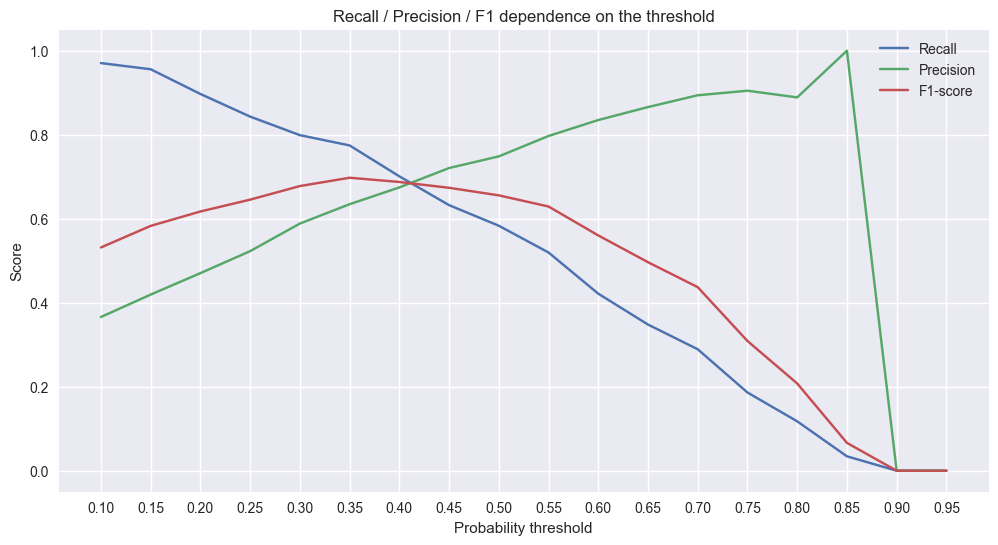

In [25]:
# нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = rf_clf.predict_proba(X_test)[:, 1]

# для удобства завернём numpy-массив в Pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)

# создаём списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []

# генерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

# в цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    # клиентов, для которых вероятность ухода > threshold, относим к классу 1
    # в противном случае — к классу 0
    y_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    # считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test, y_pred))

# визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(12, 6)) # фигура + координатная плоскость

# строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')

# строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

# строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

# задаём графику название и подписываем оси
ax.set(title='Recall / Precision / F1 dependence on the threshold',
    xlabel='Probability threshold',
    ylabel='Score'
)

# устанавливаем отметки по оси x
ax.set_xticks(thresholds) 

# отображаем легенду
ax.legend();

In [26]:
# задаём оптимальный порог вероятностей
threshold_opt = 0.35

# клиентов, вероятность ухода которых > 0.35 относим к классу 1, в противном случае — к классу 0
# делаем предсказание на тренировочной выборке
y_train_proba_pred = rf_clf.predict_proba(X_train)[:, 1]
y_train_proba_pred = pd.Series(y_train_proba_pred)
y_train_pred_rf_clf_opt = y_train_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

# делаем предсказание на тестовой выборке
y_test_pred_rf_clf_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

## вывод отчет о метриках классификации
# ТРЕНИРОВОЧНАЯ ВЫБОРКА
print(f'Train data "Accuracy": {metrics.accuracy_score(y_train, y_train_pred_rf_clf_opt):.3f}')
print(f'Train data "Precision": {metrics.precision_score(y_train, y_train_pred_rf_clf_opt):.3f}')
print(f'Train data "Recall": {metrics.recall_score(y_train, y_train_pred_rf_clf_opt):.3f}')
print(f'Train data "F1 score": {metrics.f1_score(y_train, y_train_pred_rf_clf_opt):.3f}')
print(metrics.classification_report(y_train, y_train_pred_rf_clf_opt))

# ТЕСТОВАЯ ВЫБОРКА
print(f'Test data "Accuracy": {metrics.accuracy_score(y_test, y_test_pred_rf_clf_opt):.3f}')
print(f'Test data "Precision": {metrics.precision_score(y_test, y_test_pred_rf_clf_opt):.3f}')
print(f'Test data "Recall": {metrics.recall_score(y_test, y_test_pred_rf_clf_opt):.3f}')
print(f'Test data "F1 score": {metrics.f1_score(y_test, y_test_pred_rf_clf_opt):.3f}')
print(metrics.classification_report(y_test, y_test_pred_rf_clf_opt))

Train data "Accuracy": 0.841
Train data "Precision": 0.729
Train data "Recall": 0.808
Train data "F1 score": 0.767
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1271
           1       0.73      0.81      0.77       610

    accuracy                           0.84      1881
   macro avg       0.82      0.83      0.82      1881
weighted avg       0.85      0.84      0.84      1881

Test data "Accuracy": 0.782
Test data "Precision": 0.635
Test data "Recall": 0.775
Test data "F1 score": 0.698
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       424
           1       0.63      0.77      0.70       204

    accuracy                           0.78       628
   macro avg       0.76      0.78      0.76       628
weighted avg       0.80      0.78      0.79       628



#### **Выводы:**<br>
Поскольку начиная с вероятности 0.35 визуально образуется, так называемый, максимум $F_{1}$-меры - целевой метрики, оно же является "переломным" значением, перебор иных значений `threshold_opt` отличных от 0.35 не привел к улучшению результата значений по остальным метрикам, включая целевую, при данном значении вероятности - 0.35  максимальных значений достигают все метрики в совокупности.

При выбранном значении вероятности и выбранной модели "случайный лес", предсказание ещё дополнительно улучшено на почти 10%

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
> * добавить признаки дополнительные признаки; 
> * произвести кодирование категориальных признаков;
> * произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
> * сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [27]:
# создаём объект Series, конвертируем в Dataframe,
# транспонируем из вертикального представления в горизонтальный
new_client = pd.DataFrame(pd.Series({
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
},
name='Vasiliy')
).T

# смотрим результат
new_client

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Vasiliy,[601.0],[Male],[42.0],[1.0],[98495.72],[1.0],[1.0],[0.0],[40014.76]


In [28]:
# "очистка" значений
for col in new_client.columns:
    new_client[col] = new_client[col].apply(lambda x: str(x).strip('[').strip(']'))
    new_client[col] = new_client[col].apply(lambda x: str(x).replace("'", ''))

# перекодируем единичный текстовый категориальный признак 'Gender' в бинарный столбец (1 — 'Male', 0 — 'Female')
new_client['Gender'] = new_client['Gender'].apply(lambda x: 1 if x=='Male' else 0)

# преобразование типов к численному
for col in new_client.columns:
    new_client[col] = pd.to_numeric(new_client[col])

# преобразование типов признаков в соответствии с признаками в датасете churn_data
new_client[['CreditScore', 'Gender', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']] = new_client[[
    'CreditScore', 'Gender', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']].apply(int)
new_client[['Balance', 'EstimatedSalary']] = new_client[[
    'Balance', 'EstimatedSalary']].astype(float)

# формирование дополнительных признаков
new_client['BalanceSalaryRatio'] = new_client['Balance'] / new_client['EstimatedSalary']
new_client['TenureByAge'] = new_client['Tenure'] / (new_client['Age'])
new_client['CreditScoreGivenAge'] = new_client['CreditScore'] / (new_client['Age'])

# смотрим результат
new_client
new_client.info()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
Vasiliy,601,1,42,1,98495.72,1,1,0,40014.76,2.461485,0.02381,14.309524


<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, Vasiliy to Vasiliy
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CreditScore          1 non-null      int64  
 1   Gender               1 non-null      int64  
 2   Age                  1 non-null      int64  
 3   Tenure               1 non-null      int64  
 4   Balance              1 non-null      float64
 5   NumOfProducts        1 non-null      int64  
 6   HasCrCard            1 non-null      int64  
 7   IsActiveMember       1 non-null      int64  
 8   EstimatedSalary      1 non-null      float64
 9   BalanceSalaryRatio   1 non-null      float64
 10  TenureByAge          1 non-null      float64
 11  CreditScoreGivenAge  1 non-null      float64
dtypes: float64(5), int64(7)
memory usage: 104.0+ bytes


In [29]:
## предсказание на основе модели RandomForestClassifier
# делаем предсказание вероятностей
y_new_client_proba_predict_rf_clf = rf_clf.predict_proba(new_client)

# выводим предсказанные вероятности
print(f'Predicted probabilities: {np.round(y_new_client_proba_predict_rf_clf, 2)}')

# делаем предсказание класса
y_new_client_predict_rf_clf = rf_clf.predict(new_client)

# выводим предсказанный класс
print(f'Predicted class: {y_new_client_predict_rf_clf}')

# выводим вердикт по клиенту
if y_new_client_predict_rf_clf:
    print(f'Client will exit with probability {(y_new_client_proba_predict_rf_clf[0, 1] * 100):.2f}%')
else:
    print(f'Client will stay with probability {(y_new_client_proba_predict_rf_clf[0, 0] * 100):.2f}%')

Predicted probabilities: [[0.39 0.61]]
Predicted class: [1]
Client will exit with probability 61.43%


In [30]:
## предсказание на основе модели логистической регрессии с SGD
# производим нормализацию тренировочной выборки
new_client_scaled = scaler.transform(new_client)

# генерируем полиномиальные признаки для тренировочной выборки
new_client_scaled_poly = poly.transform(new_client_scaled)

# делаем предсказание вероятностей
y_new_client_proba_predict_lr_poly = lr_poly.predict_proba(new_client_scaled_poly)

# выводим предсказанные вероятности
print(f'Predicted probabilities: {np.round(y_new_client_proba_predict_lr_poly, 2)}')

# делаем предсказание класса
y_new_client_pred_lr_poly = lr_poly.predict(new_client_scaled_poly)

# выводим предсказанный класс
print(f'Predicted class: {y_new_client_pred_lr_poly}')

# выводим вердикт по клиенту
if y_new_client_pred_lr_poly:
    print(f'Client will exit with probability {(y_new_client_proba_predict_lr_poly[0, 1] * 100):.2f}%')
else:
    print(f'Client will stay with probability {(y_new_client_proba_predict_lr_poly[0, 0] * 100):.2f}%')

Predicted probabilities: [[0.31 0.69]]
Predicted class: [1]
Client will exit with probability 68.57%


#### **Выводы:**<br>

1. На основании модели случайного леса - вероятность ухода клиента составляет 61.43%
2. На основании модели логистической регрессии со стохастическим градиентным спуском - вероятность ухода клиента составляет 68.57%

<br>

### **Общий вывод:**<br>

1. Если сравнивать модели логистической регрессии, однозначно, выигрывает модель логистической регрессии с полиномиальными коэффициентами;
2. Если сравнивать "древесные" модели, однозначно, выигрывает модель "случайного леса";
3. Если сравнивать результаты логистической регрессии с полиномиальными коэффициентами и модель "случайного леса", то их результаты сопоставимы, особенно после подстройки полиномальной модели, напомню ещё раз метрики.

Но **если отдавать предпочтение какой-то одной из них**, я бы остановил свой выбор на модели "случайного леса" по следующим причинам: 

* по метрикам (даже, если брать настройки по умолчанию, метрики у модели логистической регрессии с подобранными коэффициентами всё равно ниже), 
* по реализации, для этой модели не требуется нормализация и построение полиномиальных коэффициентов, 
* по скорости построения модели.

#### **Метрики модели "случайного леса":**

In [31]:
## вывод отчет о метриках классификации (при необходимости снять комментирование с нужных метрик)
# ТРЕНИРОВОЧНАЯ ВЫБОРКА
# print(f'Train data "Accuracy": {metrics.accuracy_score(y_train, y_train_pred_rf_clf_opt):.3f}')
# print(f'Train data "Precision": {metrics.precision_score(y_train, y_train_pred_rf_clf_opt):.3f}')
# print(f'Train data "Recall": {metrics.recall_score(y_train, y_train_pred_rf_clf_opt):.3f}')
print(f'Train data "F1 score": {metrics.f1_score(y_train, y_train_pred_rf_clf_opt):.3f}')
print(metrics.classification_report(y_train, y_train_pred_rf_clf_opt))

# ТЕСТОВАЯ ВЫБОРКА
# print(f'Test data "Accuracy": {metrics.accuracy_score(y_test, y_test_pred_rf_clf_opt):.3f}')
# print(f'Test data "Precision": {metrics.precision_score(y_test, y_test_pred_rf_clf_opt):.3f}')
# print(f'Test data "Recall": {metrics.recall_score(y_test, y_test_pred_rf_clf_opt):.3f}')
print(f'Test data "F1 score": {metrics.f1_score(y_test, y_test_pred_rf_clf_opt):.3f}')
print(metrics.classification_report(y_test, y_test_pred_rf_clf_opt))

Train data "F1 score": 0.767
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1271
           1       0.73      0.81      0.77       610

    accuracy                           0.84      1881
   macro avg       0.82      0.83      0.82      1881
weighted avg       0.85      0.84      0.84      1881

Test data "F1 score": 0.698
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       424
           1       0.63      0.77      0.70       204

    accuracy                           0.78       628
   macro avg       0.76      0.78      0.76       628
weighted avg       0.80      0.78      0.79       628



#### **Метрики модели логистической регрессии с полиномиальными коэффициентами:**

In [32]:
## вывод отчет о метриках классификации (при необходимости снять комментирование с нужных метрик)
# ТРЕНИРОВОЧНАЯ ВЫБОРКА
# print(f'Train data "Accuracy": {metrics.accuracy_score(y_train, y_train_pred_lr_poly_opt):.3f}')
# print(f'Train data "Precision": {metrics.precision_score(y_train, y_train_pred_lr_poly_opt):.3f}')
# print(f'Train data "Recall": {metrics.recall_score(y_train, y_train_pred_lr_poly_opt):.3f}')
print(f'Train data "F1 score": {metrics.f1_score(y_train, y_train_pred_lr_poly_opt):.3f}')
print(metrics.classification_report(y_train, y_train_pred_lr_poly_opt))

# ТЕСТОВАЯ ВЫБОРКА
# print(f'Test data "Accuracy": {metrics.accuracy_score(y_test, y_test_pred_lr_poly_opt):.3f}')
# print(f'Test data "Precision": {metrics.precision_score(y_test, y_test_pred_lr_poly_opt):.3f}')
# print(f'Test data "Recall": {metrics.recall_score(y_test, y_test_pred_lr_poly_opt):.3f}')
print(f'Test data "F1 score": {metrics.f1_score(y_test, y_test_pred_lr_poly_opt):.3f}')
print(metrics.classification_report(y_test, y_test_pred_lr_poly_opt))

Train data "F1 score": 0.743
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1271
           1       0.74      0.75      0.74       610

    accuracy                           0.83      1881
   macro avg       0.81      0.81      0.81      1881
weighted avg       0.83      0.83      0.83      1881

Test data "F1 score": 0.700
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       424
           1       0.69      0.72      0.70       204

    accuracy                           0.80       628
   macro avg       0.77      0.78      0.78       628
weighted avg       0.80      0.80      0.80       628

